## Cодержание:
* [First Bullet Header](#first-bullet)
* [Second Bullet Header](#second-bullet)

# Команда: Бета Банк 


**Цель:** Создать CLTV модель, которая будет выдавать вероятности перехода в каждый из 17 продуктовых кластеров в течение 12 месяцев.

Альфа-Банком предоставлены следующие **данные**, описание из файла **feature_description.xlsx**:

-   **`train_data.pqt`и `test_data.pqt` – данные о клиентах за 3 месяца:**
   
    Возможно тут описание длатасета
    - `st_id` – захэшированное id магазина;
    - `pr_sku_id` – захэшированное id товара;
    - `date` – дата;
    - `pr_sales_type_id` – флаг наличия промо;
    - `pr_sales_in_units` – число проданных товаров без признака промо;
    - `pr_promo_sales_in_units` – число проданных товаров с признаком промо;
    - `pr_sales_in_rub` – продажи без признака промо в РУБ;
    - `pr_promo_sales_in_rub` – продажи с признаком промо в РУБ;


  
Метрикой качества выступает **ROC-AUC**.

Данные о клиентах и масскированы.

## Библиотеки

In [36]:
# Необходимые библиотеки
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
import warnings
from IPython.display import display, HTML


import os
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
# import optuna
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



import numpy as np
import time
import json

import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_rows', 93)

# Отключить все предупреждения временно
import warnings
warnings.filterwarnings("ignore")

## Задание 

1. Качественно оформите код модели
2. Доработка решения на платформе будет открыта до 18 апреля 12:00
3. Обязательно наличие .README;
4. Код должен быть читабелен и понятен;
5. Решение должно быть воспроизводимо: эксперты должны иметь возможность протестировать ваше решение на финале.

## Загрузка и изучение данных

In [22]:
def read_df(path: str) -> pd.DataFrame:
    """
    Функция для чтения DataFrame из Parquet-файла.

    Параметры:
    path (str): Путь к Parquet-файлу.

    Возвращает:
    pd.DataFrame: DataFrame, прочитанный из Parquet-файла.

    """
    if os.path.exists(path):
        df = pd.read_parquet(path)
        print(f'Успешно: Данные {path} загружены')
        return df
    else:
        print(f'Ошибка: {path} не найден')
        return None

In [23]:
# Путь до файла train_df
path_train_df = "../data/raw/train_data.pqt"

# Путь до файла test_df
path_test_df = "../data/raw/test_data.pqt"

train_df = read_df(path=path_train_df)
test_df = read_df(path=path_test_df)

Успешно: Данные ../data/raw/train_data.pqt загружены
Успешно: Данные ../data/raw/test_data.pqt загружены


In [ ]:
## Jgbcf

### Описание

In [29]:
# Функция для описание датасета

def column_summary(df):

    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(
                10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(
                top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        if np.issubdtype(col_dtype, np.number):
            mean = df[col_name].mean()
            std = df[col_name].std()
            min_val = df[col_name].min()
            q25 = df[col_name].quantile(0.25)
            q50 = df[col_name].quantile(0.50)
            q75 = df[col_name].quantile(0.75)
            max_val = df[col_name].max()
        else:
            mean, std, min_val, q25, q50, q75, max_val = [None] * 7

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts,
            'mean': mean,
            'std': std,
            'min': min_val,
            'q25': q25,
            'q50': q50,
            'q75': q75,
            'max': max_val,
        })

    return pd.DataFrame(summary_data)

In [38]:
display(HTML('<h2>TRAIN</h2>'))

display(column_summary(train_df))

display(HTML('<h2>TEST</h2>'))

display(column_summary(test_df))

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts,mean,std,min,q25,q50,q75,max
0,id,int64,0,600000,200000,"{0: 3, 133350: 3, 133328: 3, 133329: 3, 133330...",99999.5000,57735.0750,0.0000,49999.7500,99999.5000,149999.2500,199999.0000
1,date,object,0,600000,3,"{'month_1': 200000, 'month_2': 200000, 'month_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,balance_amt_avg,float64,65577,534423,422801,"{-0.15671199607667008: 5120, -0.15641139940462...",0.0000,1.0000,-0.1568,-0.1561,-0.1499,-0.1034,154.2407
3,balance_amt_max,float64,65577,534423,384683,"{-0.2046870733446079: 6825, -0.204912823030284...",-0.0000,1.0000,-0.2050,-0.2043,-0.1903,-0.1063,117.4957
4,balance_amt_min,float64,65577,534423,271836,"{-0.1259950191492185: 83156, -0.12583102560670...",-0.0000,1.0000,-0.1260,-0.1259,-0.1249,-0.1125,91.4508
5,balance_amt_day_avg,float64,65577,534423,421041,"{-0.15624833526334467: 5146, -0.15618147769744...",-0.0000,1.0000,-0.1563,-0.1557,-0.1496,-0.1033,154.7193
6,channel_code,object,42850,557150,45,"{'channel_code_8': 102296, 'channel_code_12': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,city,object,78344,521656,8917,"{'city_0': 86234, 'city_14': 39358, 'city_21':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,city_type,object,78344,521656,7931,"{'city_type_0': 464866, 'city_type_100': 289, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,index_city_code,object,325224,274776,233,"{'index_city_code_46': 9548, 'index_city_code_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts,mean,std,min,q25,q50,q75,max
0,id,int64,0,290120,100000,"{200000: 3, 264978: 3, 264987: 3, 264986: 3, 2...",250005.7351,28867.6004,200000.0000,225020.7500,249994.0000,275004.0000,299999.0000
1,date,object,0,290120,3,"{'month_5': 100000, 'month_6': 100000, 'month_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,balance_amt_avg,float64,29483,260637,209126,"{-0.15671199607667008: 2146, -0.15641139940462...",-0.0205,0.7856,-0.1568,-0.1562,-0.1515,-0.1124,77.6946
3,balance_amt_max,float64,29483,260637,188911,"{-0.2046870733446079: 4275, -0.204912823030284...",-0.0206,0.9186,-0.2050,-0.2044,-0.1933,-0.1199,169.9907
4,balance_amt_min,float64,29483,260637,136230,"{-0.1259950191492185: 44984, -0.12583102560670...",-0.0198,0.8374,-0.1260,-0.1259,-0.1251,-0.1164,90.5838
5,balance_amt_day_avg,float64,29483,260637,207859,"{-0.15624833526334467: 2150, -0.15618147769744...",-0.0208,0.7811,-0.1563,-0.1558,-0.1512,-0.1125,77.9362
6,channel_code,object,20028,270092,40,"{'channel_code_8': 49879, 'channel_code_12': 3...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,city,object,60612,229508,3622,"{'city_0': 38800, 'city_14': 17091, 'city_21':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,city_type,object,60992,229128,2694,"{'city_type_0': 205749, 'city_type_7557': 4989...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,index_city_code,object,156461,133659,225,"{'index_city_code_46': 5426, 'index_city_code_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN



1. В train Слишком много повторяющиеся значений в столбцах `sum_*`
2. Минимум иногда больше максимума P.S Я НЕ ЗНАЮ НОРМ ЛИ ЭТО ДЛЯ МАКСИРОВАННЫХ ДАННЫХ 
3. Скорее всего стоит удалить признаки sum_ слишком много один и тех же значений

### Дубликаты

In [51]:
train_df[train_df.duplicated(subset=train_df.columns.difference(['id']), keep=False)].T

,15,16,45,46,54,78,84,108,109,111,...,599802,599856,599862,599874,599904,599905,599934,599935,599937,599949
id,5,5,15,15,18,26,28,36,36,37,...,199934,199952,199954,199958,199968,199968,199978,199978,199979,199983
date,month_1,month_2,month_1,month_2,month_1,month_1,month_1,month_1,month_2,month_1,...,month_1,month_1,month_1,month_1,month_1,month_2,month_1,month_2,month_1,month_1
balance_amt_avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance_amt_max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance_amt_min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance_amt_day_avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
channel_code,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
city,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
city_type,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
index_city_code,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [54]:
test_df[test_df.duplicated(subset=test_df.columns.difference(['id']), keep=False)].T

,12,23,25,36,39,50,94,102,110,133,...,289933,289936,290001,290018,290054,290083,290094,290096,290101,290115
id,200004,200008,200009,200013,200014,200018,200033,200036,200039,200047,...,299935,299936,299958,299964,299976,299986,299990,299991,299993,299998
date,month_5,month_5,month_5,month_4,month_5,month_5,month_5,month_5,month_5,month_5,...,month_4,month_5,month_5,month_4,month_5,month_5,month_5,month_5,month_5,month_5
balance_amt_avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance_amt_max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance_amt_min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance_amt_day_avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
channel_code,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
city,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
city_type,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
index_city_code,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


* Есть дубликаты индетичные копиии клиентов

### Пустые значения

In [64]:
def plt_null_df(df: pd.DataFrame, df_name: str) -> None:
    plt.figure(figsize=(15, 8))
    plt.imshow(df.isna(), aspect="auto",
               interpolation="nearest", cmap="viridis")
    plt.title(f"Пустые значения в {df_name}")
    plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')
    plt.xlabel("Column Number")
    plt.ylabel("Sample Number")
    plt.show()



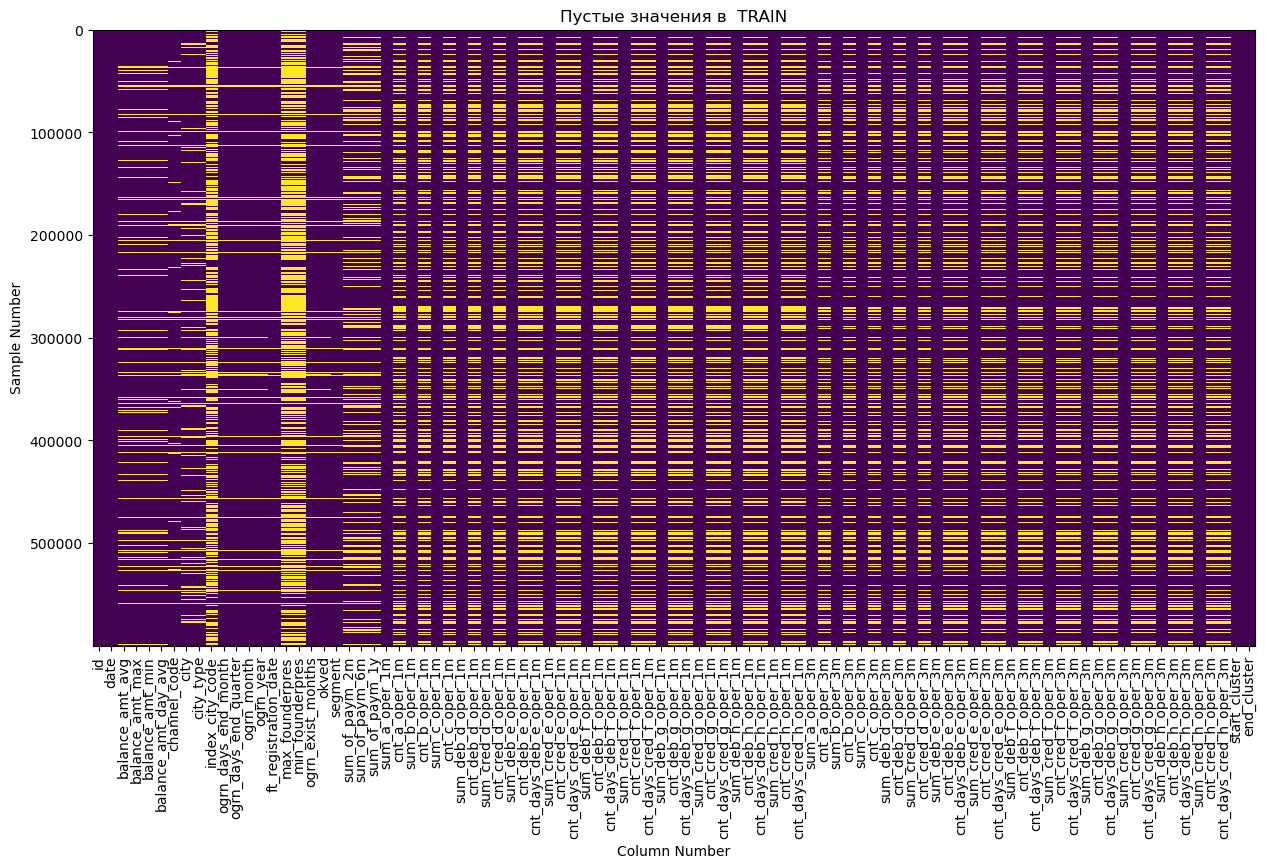

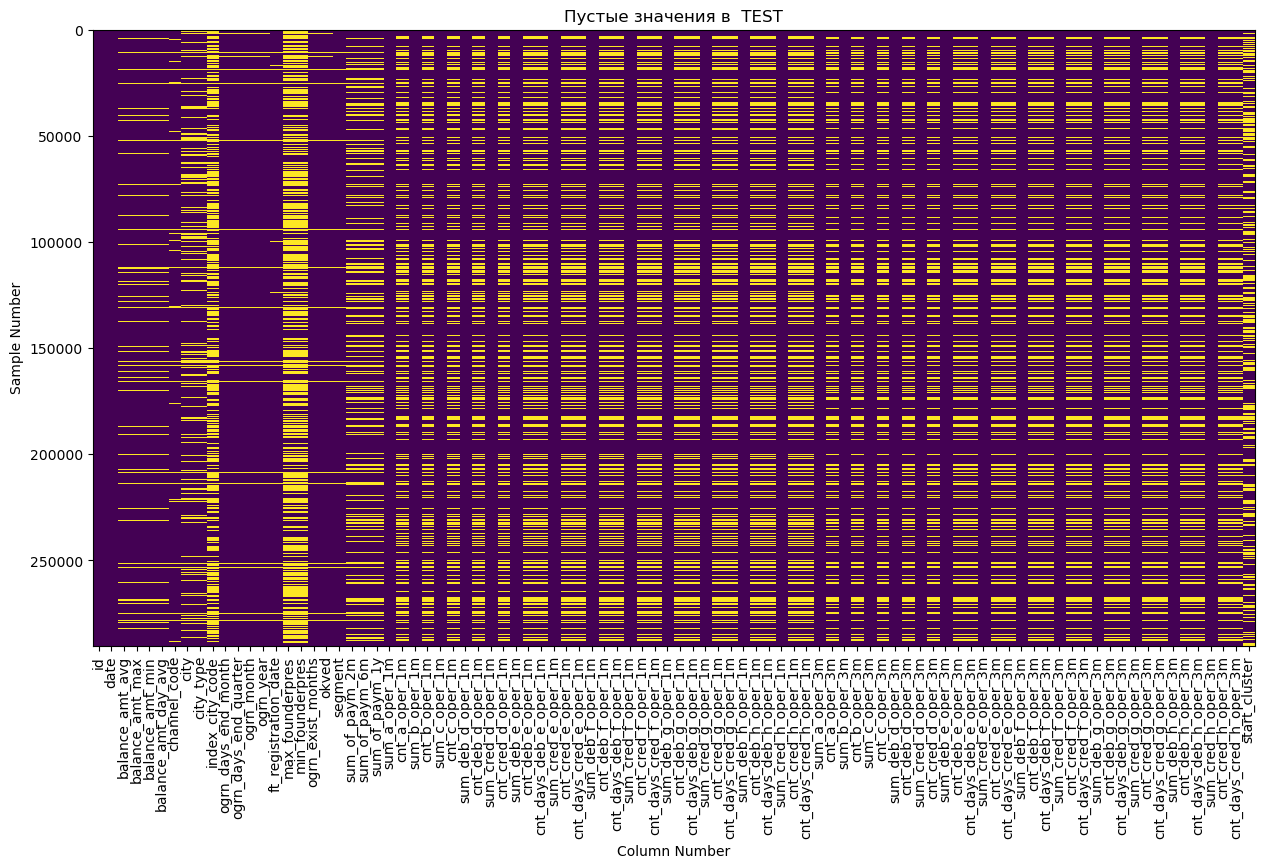

In [65]:
plt_null_df(train_df, " TRAIN")
plt_null_df(test_df, " TEST")

* Одинаково распределены

### 3 месяца категорий одно значение

In [41]:
def calculate_summary(df):
    summary_data = []

    for column in df.select_dtypes(exclude='number').columns:
        num_clients_all_filled = df.groupby('id')[column].apply(
            lambda x: len(x.dropna()) == 3).sum()
        num_clients_one_value = df.groupby('id')[column].apply(
            lambda x: len(set(x)) == 1 and len(x.dropna()) == 3).sum()

        summary_data.append({
            'Column': column,
            'Clients_all_filled': num_clients_all_filled,
            'Clients_one_value': num_clients_one_value
        })

    summary_df = pd.DataFrame(summary_data)

    return summary_df

In [42]:
display(HTML('<h2>TRAIN</h2>'))

display(calculate_summary(train_df))

display(HTML('<h2>TEST</h2>'))

display(calculate_summary(test_df))

,Column,Clients_all_filled,Clients_one_value
0,date,200000,0
1,channel_code,176084,176055
2,city,165739,165217
3,city_type,165739,165412
4,index_city_code,87853,87528
5,ogrn_month,180209,180196
6,ogrn_year,180209,180196
7,okved,180070,179459
8,segment,180214,180168
9,start_cluster,200000,160086


,Column,Clients_all_filled,Clients_one_value
0,date,90120,0
1,channel_code,84209,84194
2,city,72059,71984
3,city_type,71942,70641
4,index_city_code,42278,42071
5,ogrn_month,86046,86031
6,ogrn_year,86046,86028
7,okved,85976,85568
8,segment,86119,85640
9,start_cluster,0,0


* Чаще всего у клиентов категориальные данные заполнены один значением в 3 месяцах. Кроме start_cluster и end_cluster. 

### Итог

в конце общий итог

## Предобработка данных

### Объединение датасетов


In [70]:
df = pd.concat([train_df, test_df], ignore_index=True)

## Разведочный анализ данных

### Уникальные значения 

<Axes: title={'center': 'Unique values per feature'}>

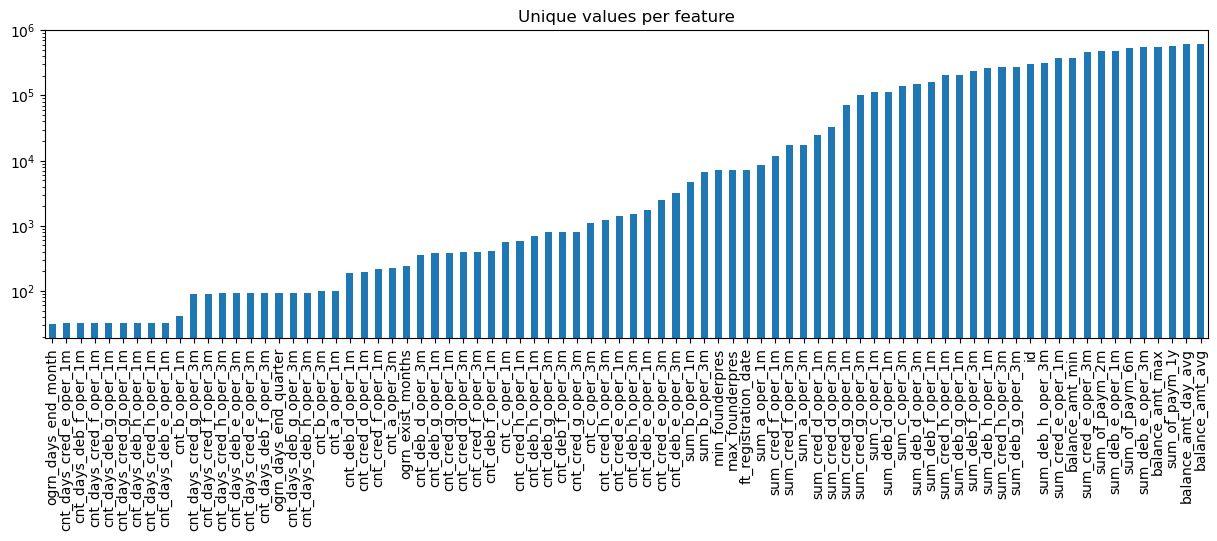

In [71]:
unique_values = df.select_dtypes(include="number").nunique().sort_values()

unique_values.plot.bar(logy=True, figsize=(
    15, 4), title="Unique values per feature")

### Выбросы

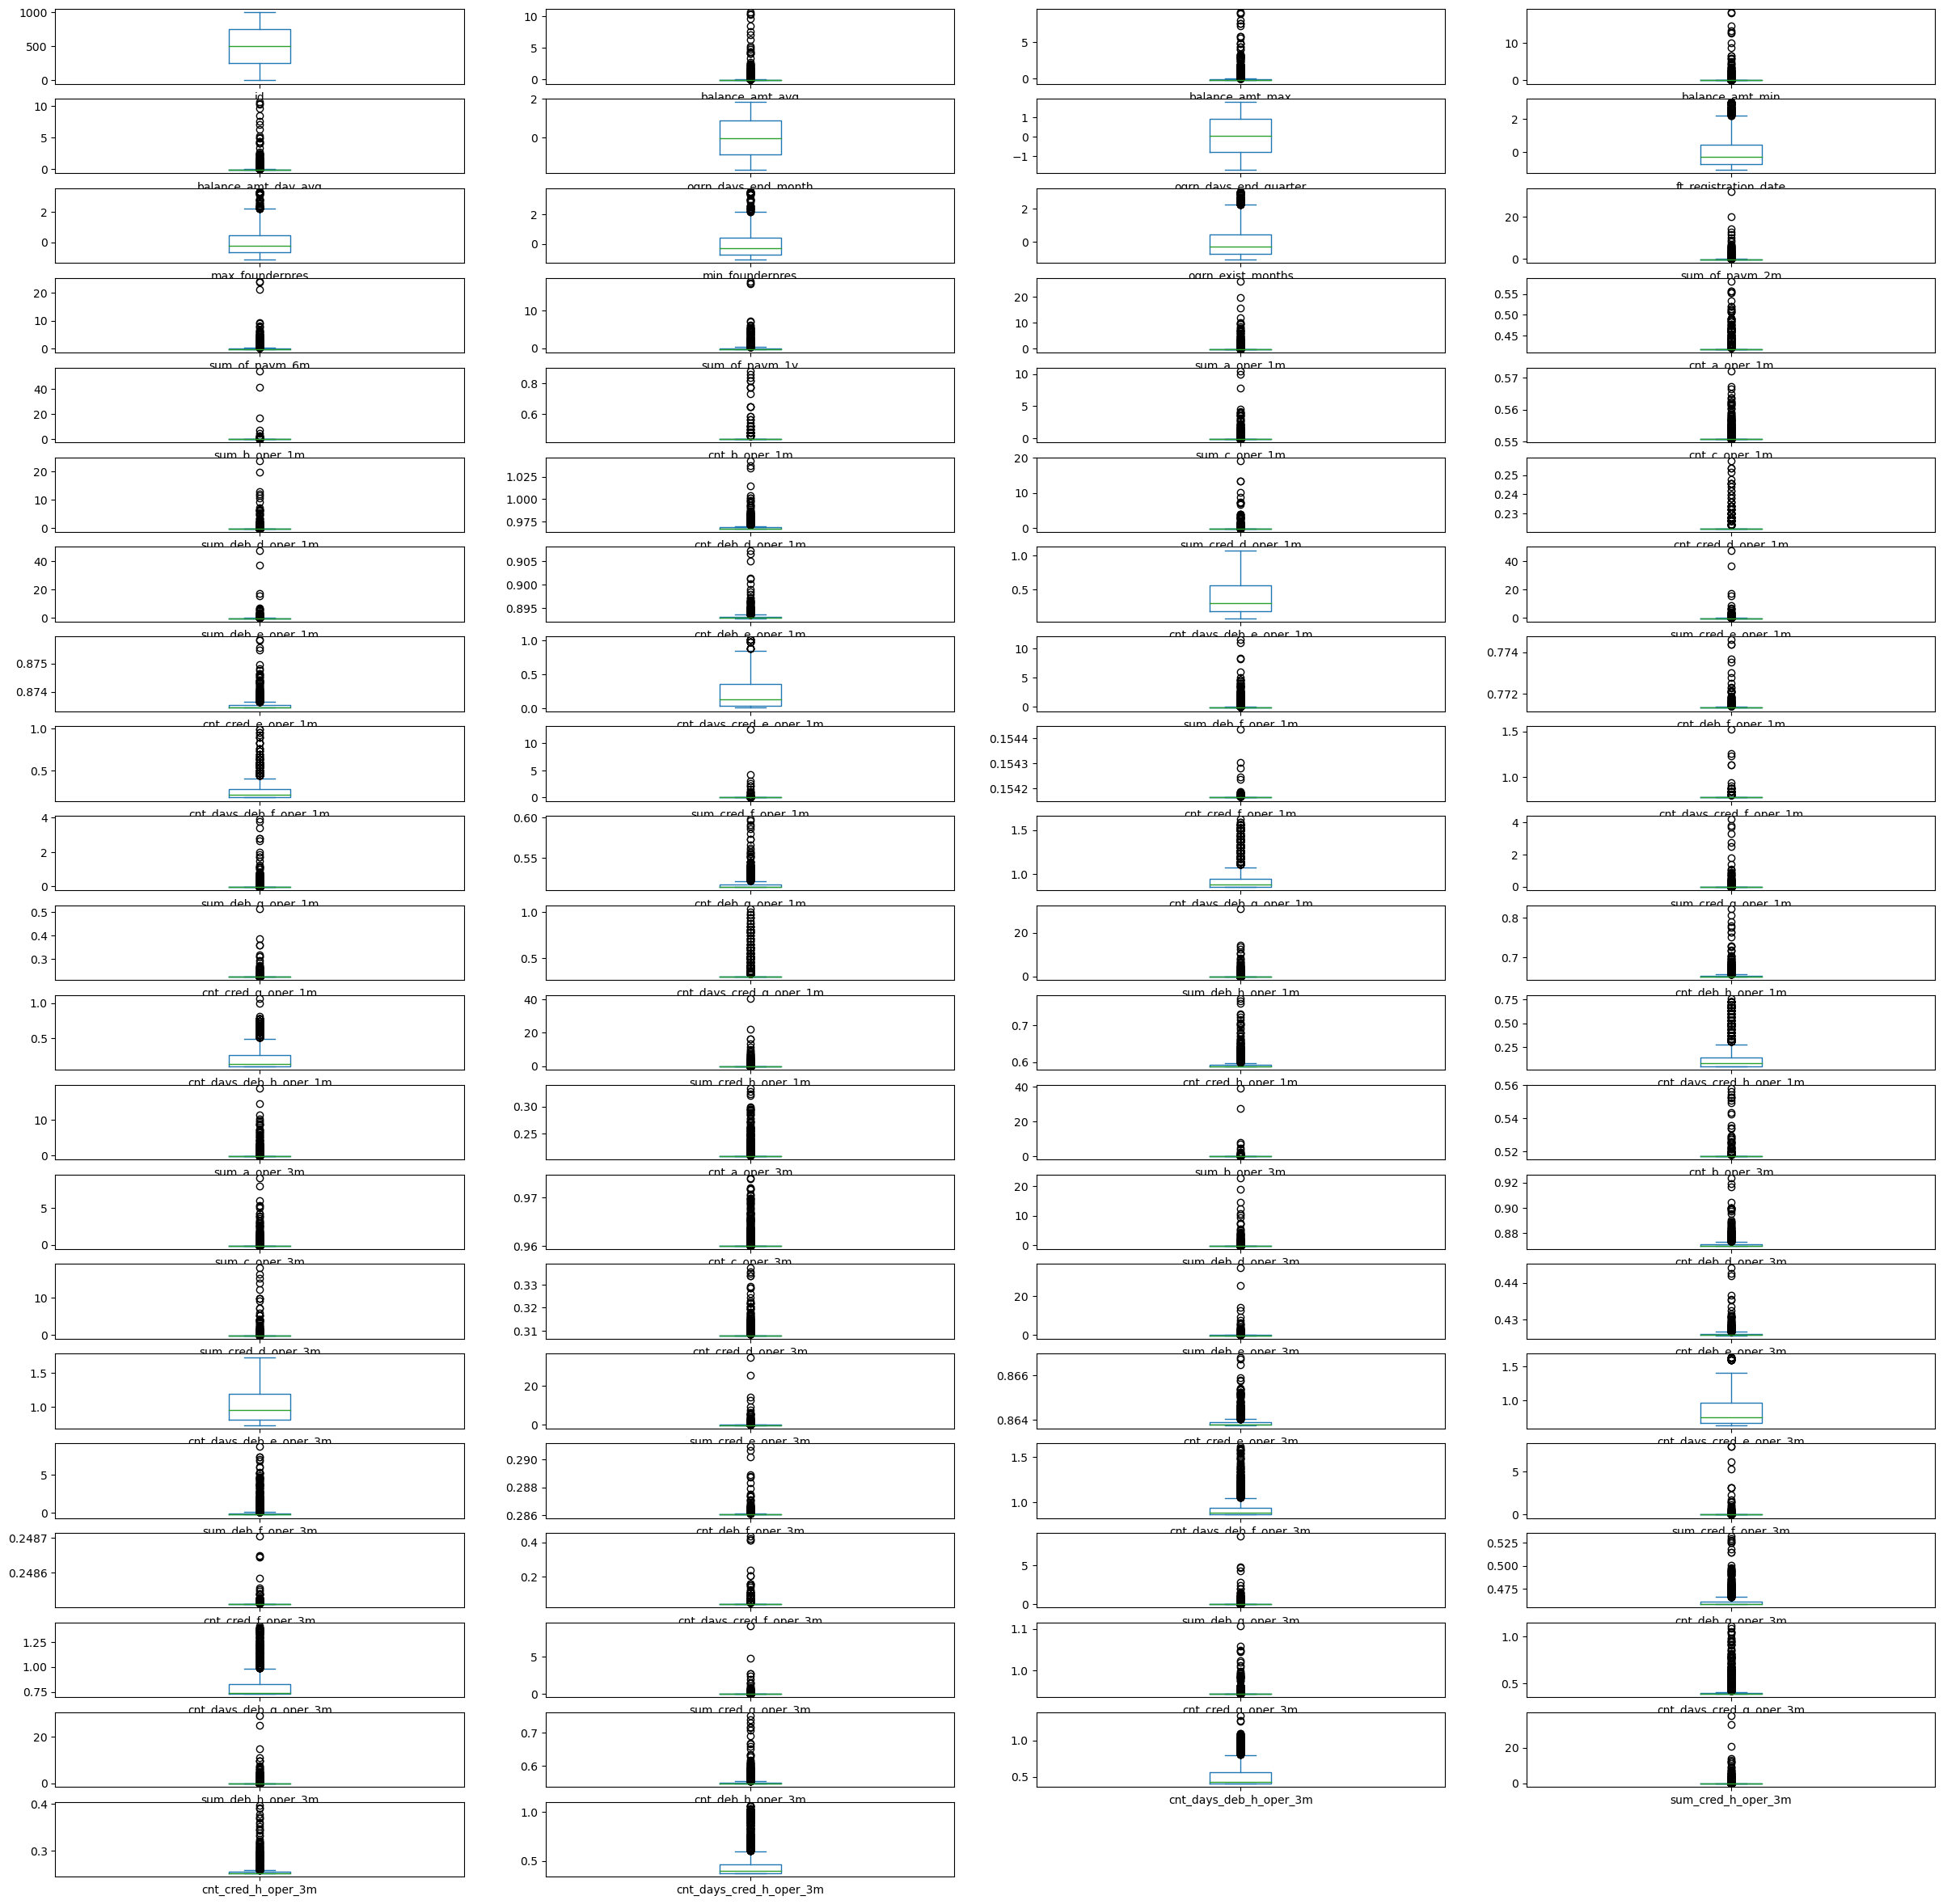

In [72]:
df[df.select_dtypes(include='number').columns][:3000].plot(kind='box', subplots=True, layout=(-1, 4),
                                                           figsize=(30, 30))

plt.show()

### Корреляционный анализ

In [76]:
def plt_corr_df(df):

  corr_df = df.select_dtypes(include='number').corr().abs()
  mask = np.triu(np.ones_like(corr_df, dtype=bool))
  plt.figure(figsize=(20, 15))
  sns.heatmap(corr_df, cmap="YlGnBu", annot=True,
              fmt=".1f", annot_kws={'size': 5}, mask=mask)
  plt.title("Матрица коэффициентов корреляции")
  plt.show()


def get_columns_corr(df, p: int):
    corr_df = df.select_dtypes(include='number').corr().abs()
    c1 = corr_df.unstack()

    c1_sorted = c1.sort_values(ascending=True)
    columns_above = {(col1, col2): c1_sorted[col1, col2] for col1,
                     col2 in c1_sorted.index if c1_sorted[col1, col2] > p and col1 != col2}

    return dict(sorted(columns_above.items(), key=lambda item: item[1], reverse=True))

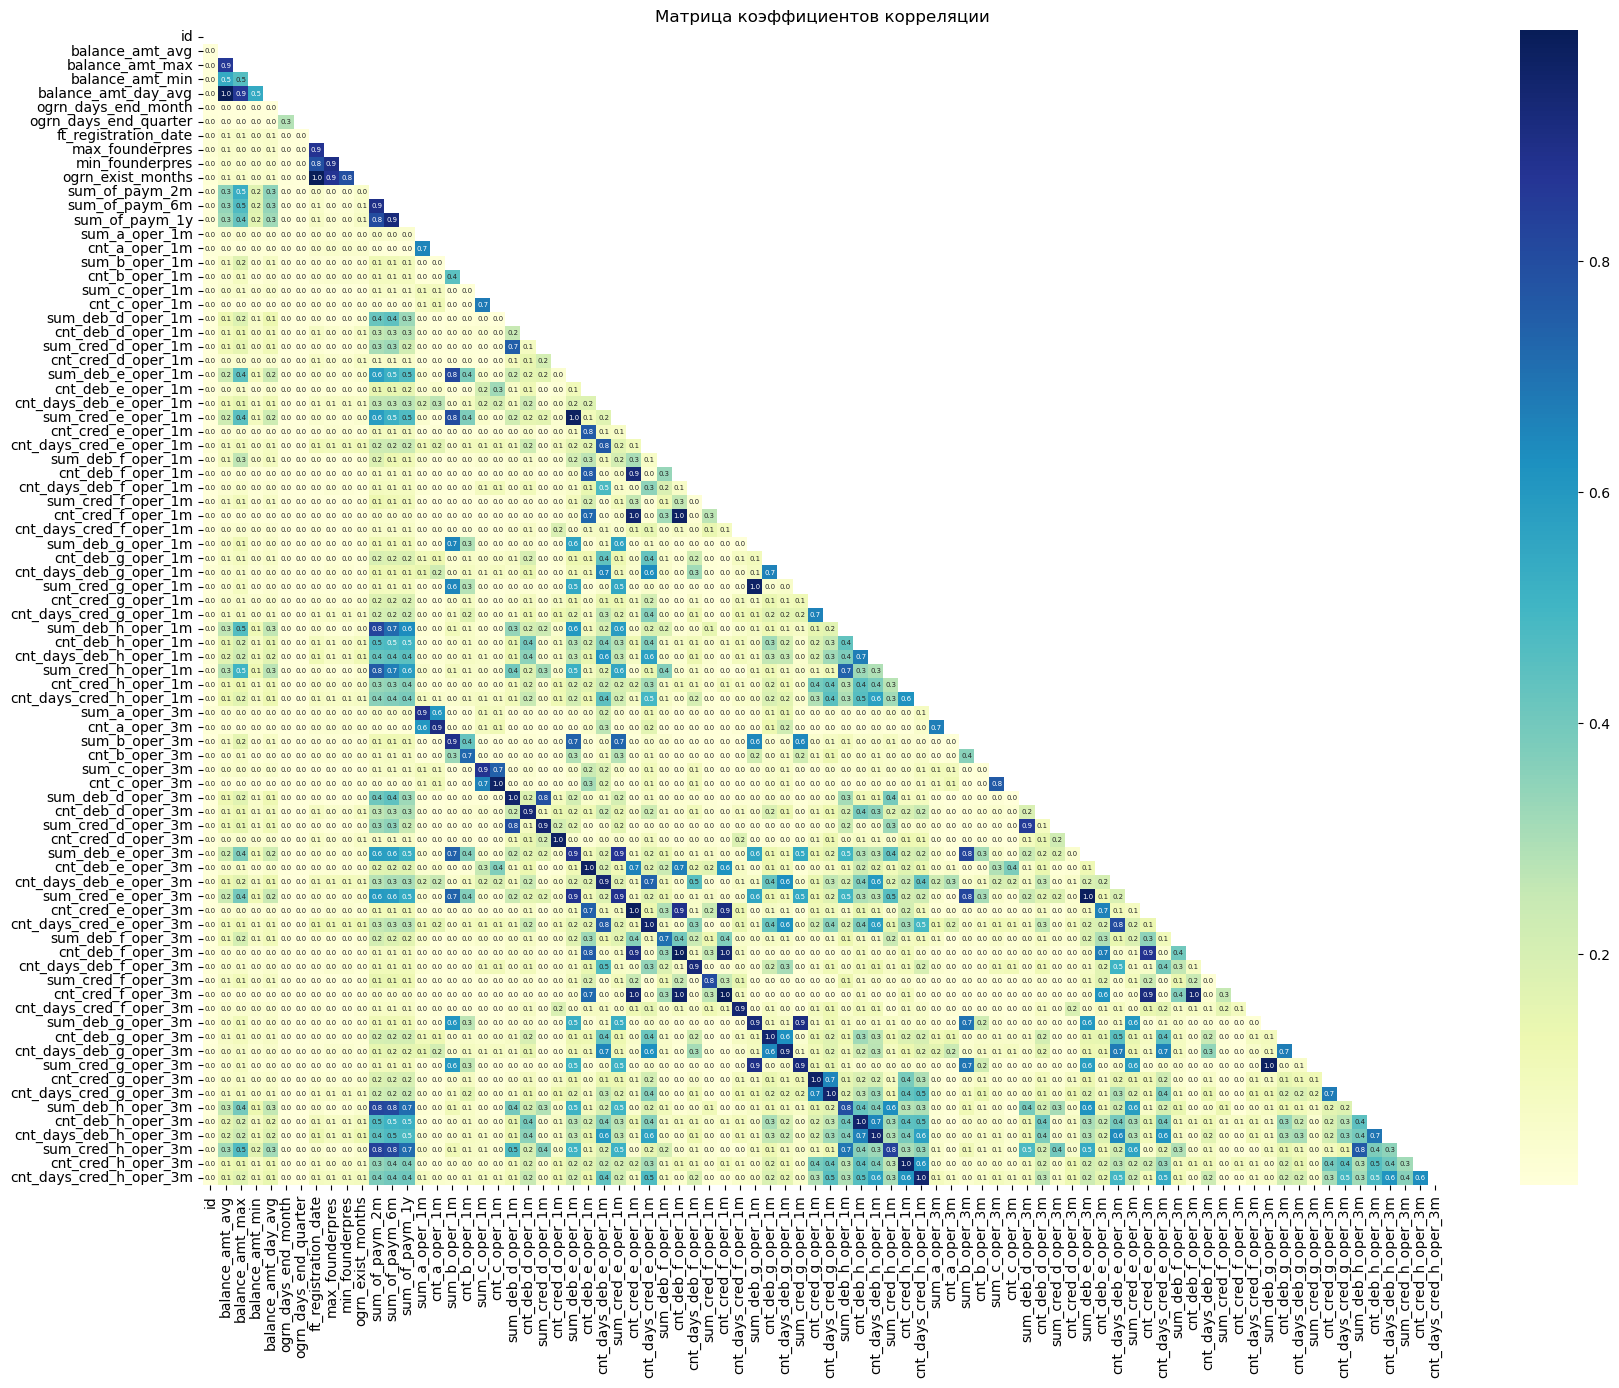

In [77]:
plt_corr_df(df)

In [78]:
get_columns_corr(df, p = 0.9)

{('ogrn_exist_months', 'ft_registration_date'): 0.9998762737464166,
 ('ft_registration_date', 'ogrn_exist_months'): 0.9998762737464166,
 ('balance_amt_avg', 'balance_amt_day_avg'): 0.9984710888922917,
 ('balance_amt_day_avg', 'balance_amt_avg'): 0.9984710888922917,
 ('cnt_cred_f_oper_1m', 'cnt_cred_f_oper_3m'): 0.9947826509914572,
 ('cnt_cred_f_oper_3m', 'cnt_cred_f_oper_1m'): 0.9947826509914572,
 ('cnt_deb_f_oper_1m', 'cnt_deb_f_oper_3m'): 0.9935044458891936,
 ('cnt_deb_f_oper_3m', 'cnt_deb_f_oper_1m'): 0.9935044458891936,
 ('cnt_cred_e_oper_1m', 'cnt_cred_e_oper_3m'): 0.985436795276794,
 ('cnt_cred_e_oper_3m', 'cnt_cred_e_oper_1m'): 0.985436795276794,
 ('sum_cred_e_oper_3m', 'sum_deb_e_oper_3m'): 0.98534151074155,
 ('sum_deb_e_oper_3m', 'sum_cred_e_oper_3m'): 0.98534151074155,
 ('sum_deb_e_oper_1m', 'sum_cred_e_oper_1m'): 0.9793286515432401,
 ('sum_cred_e_oper_1m', 'sum_deb_e_oper_1m'): 0.9793286515432401,
 ('cnt_deb_e_oper_3m', 'cnt_deb_e_oper_1m'): 0.9791128053215934,
 ('cnt_deb_e_

### Колонки с повторяющимся значениями 

In [79]:
def find_columns_with_high_repeated_values(df, threshold):
    columns_with_high_repeated_values = []
    for col in df.columns:
        value_counts = df[col].value_counts()
        if value_counts.max() >= threshold:
            columns_with_high_repeated_values.append(col)
    return columns_with_high_repeated_values

In [80]:
threshold = 500000
columns_with_high_repeated_values = find_columns_with_high_repeated_values(
    df, threshold)
print("Столбцы, в которых значение встречается {} и более раз:".format(threshold))
print(columns_with_high_repeated_values)

Столбцы, в которых значение встречается 500000 и более раз:
['city_type', 'segment', 'sum_a_oper_1m', 'cnt_a_oper_1m', 'sum_b_oper_1m', 'cnt_b_oper_1m', 'sum_c_oper_1m', 'sum_deb_d_oper_1m', 'sum_cred_d_oper_1m', 'cnt_cred_d_oper_1m', 'sum_deb_f_oper_1m', 'sum_cred_f_oper_1m', 'cnt_cred_f_oper_1m', 'cnt_days_cred_f_oper_1m', 'sum_deb_g_oper_1m', 'sum_cred_g_oper_1m', 'sum_deb_h_oper_1m', 'sum_cred_h_oper_1m', 'sum_a_oper_3m', 'cnt_a_oper_3m', 'sum_b_oper_3m', 'cnt_b_oper_3m', 'sum_c_oper_3m', 'sum_deb_d_oper_3m', 'sum_cred_d_oper_3m', 'cnt_cred_d_oper_3m', 'sum_deb_f_oper_3m', 'sum_cred_f_oper_3m', 'cnt_cred_f_oper_3m', 'cnt_days_cred_f_oper_3m', 'sum_deb_g_oper_3m', 'sum_cred_g_oper_3m']


## Feature engineering

Тут кратко описание секции

###  AVG

Очень много плохих столбцов sum но  cnt хорошие и можно сгенирировать avg

In [ ]:
df['avg_a_oper_1m'] = df['sum_a_oper_1m'] / df['cnt_a_oper_1m']
df['avg_b_oper_1m'] = df['sum_b_oper_1m'] / df['cnt_b_oper_1m']
df['avg_c_oper_1m'] = df['sum_c_oper_1m'] / df['cnt_c_oper_1m']

df['avg_deb_d_oper_1m'] = df['sum_deb_d_oper_1m'] / df['cnt_deb_d_oper_1m']
df['avg_cred_d_oper_1m'] = df['sum_cred_d_oper_1m'] / df['cnt_cred_d_oper_1m']

df['avg_deb_e_oper_1m'] = df['sum_deb_e_oper_1m'] / df['cnt_deb_e_oper_1m']
df['avg_cred_e_oper_1m'] = df['sum_cred_e_oper_1m'] / df['cnt_cred_e_oper_1m']


df['avg_deb_f_oper_1m'] = df['sum_deb_f_oper_1m'] / df['cnt_deb_f_oper_1m']
df['avg_cred_f_oper_1m'] = df['sum_cred_f_oper_1m'] / df['cnt_cred_f_oper_1m']

df['avg_deb_g_oper_1m'] = df['sum_deb_g_oper_1m'] / df['cnt_deb_g_oper_1m']
df['avg_cred_g_oper_1m'] = df['sum_cred_g_oper_1m'] / df['cnt_cred_g_oper_1m']

df['avg_deb_h_oper_1m'] = df['sum_deb_h_oper_1m'] / df['cnt_deb_h_oper_1m']
df['avg_cred_h_oper_1m'] = df['sum_cred_h_oper_1m'] / df['cnt_cred_h_oper_1m']


df['avg_a_oper_3m'] = df['sum_a_oper_3m'] / df['cnt_a_oper_3m']
df['avg_b_oper_3m'] = df['sum_b_oper_3m'] / df['cnt_b_oper_3m']
df['avg_c_oper_3m'] = df['sum_c_oper_3m'] / df['cnt_c_oper_3m']

df['avg_deb_d_oper_3m'] = df['sum_deb_d_oper_3m'] / df['cnt_deb_d_oper_3m']
df['avg_cred_d_oper_3m'] = df['sum_cred_d_oper_3m'] / df['cnt_cred_d_oper_3m']

df['avg_deb_e_oper_3m'] = df['sum_deb_e_oper_3m'] / df['cnt_deb_e_oper_3m']
df['avg_cred_e_oper_3m'] = df['sum_cred_e_oper_3m'] / df['cnt_cred_e_oper_3m']

df['avg_deb_f_oper_3m'] = df['sum_deb_f_oper_3m'] / df['cnt_deb_f_oper_3m']
df['avg_cred_f_oper_3m'] = df['sum_cred_f_oper_3m'] / df['cnt_cred_f_oper_3m']

df['avg_deb_g_oper_3m'] = df['sum_deb_g_oper_3m'] / df['cnt_deb_g_oper_3m']
df['avg_cred_g_oper_3m'] = df['sum_cred_g_oper_3m'] / df['cnt_cred_g_oper_3m']

df['avg_deb_h_oper_3m'] = df['sum_deb_h_oper_3m'] / df['cnt_deb_h_oper_3m']
df['avg_cred_h_oper_3m'] = df['sum_cred_h_oper_3m'] / df['cnt_cred_h_oper_3m']

### Удаление плохих столбцов

Буду пробовать не удалять

In [ ]:
columns_to_drop = [
    'balance_amt_max',
    'balance_amt_min',
    'balance_amt_day_avg',
    'index_city_code',
    'max_founderpres',
    'min_founderpres',
    'ogrn_exist_months',
    'sum_a_oper_1m',
    'sum_b_oper_1m',
    'sum_c_oper_1m',
    'sum_deb_d_oper_1m',
    'sum_cred_d_oper_1m',
    'sum_deb_e_oper_1m',
    'sum_cred_e_oper_1m',
    'sum_deb_f_oper_1m',
    'sum_cred_f_oper_1m',
    'sum_deb_g_oper_1m',
    'sum_cred_g_oper_1m',
    'sum_deb_h_oper_1m',
    'sum_cred_h_oper_1m',
    'sum_a_oper_3m',
    'sum_b_oper_3m',
    'sum_c_oper_3m',
    'sum_deb_d_oper_3m',
    'sum_cred_d_oper_3m',
    'sum_deb_e_oper_3m',
    'sum_cred_e_oper_3m',
    'sum_deb_f_oper_3m',
    'sum_cred_f_oper_3m',
    'sum_deb_g_oper_3m',
    'sum_cred_g_oper_3m',
    'sum_deb_h_oper_3m',
    'sum_cred_h_oper_3m']


df = df.drop(columns=columns_to_drop)

### Восстановление категориальных данных

In [ ]:
cat_columns_to_restore = ['channel_code', 'city',
                          'city_type', 'ogrn_month', 'ogrn_year', 'okved', 'segment']

for column in cat_columns_to_restore:
  df[column] = df.groupby('id')[column].apply(
      lambda x: restore_cal(x)).reset_index()[column]
  print(f"Колонка - {column} - восстановлена")

### Создание таблицы с 3 месяцами 

In [ ]:
pivot_df = df.pivot_table(index='id', columns='date', aggfunc='first')

# Преобразуем мультииндексные столбцы в одноуровневые
pivot_df.columns = [f'{col[0]}_{col[1]}' for col in pivot_df.columns]

# Объединяем строки для каждого клиента в одну
pivot_df.reset_index(inplace=True)
pivot_df = pivot_df.drop(
    columns=['end_cluster_month_1', 'end_cluster_month_2'], axis=0)

df = pivot_df

categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna("missing")

### Воостановление start_claster

In [ ]:
train_data = df[df['start_cluster_month_3'] != 'missing'].drop(
    ['id',  'end_cluster_month_3'], axis=1)
predict_data = df[df['start_cluster_month_3'] == 'missing'].drop(
    ['id', 'end_cluster_month_3'], axis=1)

X = train_data.drop('start_cluster_month_3', axis=1)
y = train_data['start_cluster_month_3']

In [ ]:
model = CatBoostClassifier(iterations=2028,
                           depth=8,
                           learning_rate=0.075,
                           random_seed=47,
                           loss_function='MultiClass',
                           task_type="GPU",
                           devices='0',
                           early_stopping_rounds=20
                           )

In [ ]:
def train_catboost(model, x_train, y_train, x_val, y_val, cat_names):

    model.fit(
        x_train, y_train,
        cat_features=np.array(cat_names),
        eval_set=(x_val, y_val),
        verbose=100  # через сколько итераций выводить стату
    )
    model.save_model('catboost_model_start_claster.json')  # сохранение модели
    feature_importance = model.get_feature_importance(
        prettified=True)  # датасет с важностью признаков

    return feature_importance

In [ ]:
feature_importance = train_catboost(
    model, X_train, y_train, X_val, y_val, cat_names)

In [ ]:
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

In [ ]:
X_predict = predict_data.drop('start_cluster_month_3', axis=1)
predicted_clusters = model.predict(X_predict)

In [ ]:
predicted_index = 0

df_restore_start_cluster = df.copy()
for index, row in df_restore_start_cluster.iterrows():
    # Проверяем, содержится ли в столбце 'date' значение 'month6' и id >= 100000
    if row['id'] >= 200000:
        # Вставляем значение из серии в столбец 'start_cluster_month_3' текущей строки
        df_restore_start_cluster.at[index,
                                    'start_cluster_month_3'] = predicted_clusters[predicted_index][0]
        # Увеличиваем индекс текущей строки в серии
        predicted_index += 1

In [ ]:
matching_rows = df[df['id'] >= 200000].loc[(df_restore_start_cluster['start_cluster_month_1'] == df_restore_start_cluster['start_cluster_month_2']) & (
    df_restore_start_cluster['start_cluster_month_2'] == df_restore_start_cluster['start_cluster_month_3'])]
matching_rows

## Обучение модели <a class="anchor" id="first-bullet"></a>

## Тестирование модели

---
## Выводы и резюме

Мы решали **задачу прогнозирования временного ряда спроса товаров** собственного производства на 14 дней вперёд. 

Заказчиком предоставлены исторические данные о **продажах за 1 год**, а также в закодированном виде товарная иерархия и информация о магазинах.  
Прогнозировалось **число проданных товаров в штуках  `pr_sales_in_units`** для каждого **SKU/товара** (2050 шт. в обучающей выборке) в каждом из **10 магазинов**.

Основные **закономерности**, выявленные в результате анализа: 
- ***Годовой тренд***  - спад средних продаж в зимний сезон октябрь-март.
- ***Недельная сезонность*** - пик продаж в субботу, спад в понедельник.
- В течение года несколько высоких ***пиков спроса, в основном в районе праздников***. Самые резкие подъёмы продаж в период Нового года и Пасхи. Подъем продаж начинается за несколько дней до.
- 40,6% записей относятся к продажам по промоакциям. Возможны одновременные продажи товара в одном магазине по промо и без. 
- В данных представлены продукты с ***неполными временными рядами***: продавались только в дни около Пасхи, начали продаваться полгода назад.
- Во всех магазинах разный ассортимент товаров даже при условии одинаковых характеристик торговой точки.
- Все мета-признаки как характеристики магазинов и товаров показали влияние на средний спрос

На основе имеющихся данных **сгенерированы новые признаки:**  
- Календарные: день недели, число месяца, номер недели, флаг выходного дня (взят из доп. таблицы)
- Лаговые признаки 1-30 дней
- Скользящее среднее за 7 и 14 предыдущих дней
- Кластеризация по характеристикам магазинов и товаров
    
Чтобы временные ряды каждой комбинации Магазин-Товар были полными создан новый датасет, в который добавлены отсутствующие даты с нулевыми продажами.

 Обучение, валидация и выбор лучшего набора гиперпараметров проводится на **кросс-валидации Walk Forward**: подбор гиперпараметров на фолде проводится на valid-выборке, оценка лучшей модели на фолде на test-выборке.   
В итоге выбрана одна модель среди лучших на каждом фолде.

 Предсказание спроса обученной моделью делается последовательно на каждый следующий день с промежуточным перерасчётом лаговых признаков (учитывается предсказанное значение спроса в предыдущий день).

 Для оценки модели использовалась метрика качества  **WAPE**, посчитанная на уровне Магазин-Товар-Дата.  
 
Лучший результат по качеству и скорости показала модель градиентного бустинга **LightGBM**.  <br>
Полученный результат: WAPE = **0,47**, превышает baseline (предсказание последним известным значением) с метрикой 69%.


